In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

1. While loading dataset, 1st row became column names, so we pass 'header = None'
2. Also, the format may be csv, but the values within was **TAB** separated.

In [2]:
# 1. Load the users dataset
df1 = pd.read_csv('kaggle_visible_evaluation_triplets.txt',header=None,sep='\t')
df1.rename(columns={0:'user_id',
                    1:'song_id',
                    2:'listen_count'},inplace=True)



# 2. Load the songs dataset
df2 = pd.read_csv('song_data.csv')
df2.drop_duplicates(['song_id'],inplace=True)

In [3]:
df = df1.merge(df2,on='song_id')
df = df.head(500000)
df.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,fd50c4007b68a3737fe052d5a4f78ce8aa117f3d,SOBONKR12A58A7A7E0,1,You're The One,If There Was A Way,Dwight Yoakam,1990
1,c34670d9c1718361feb93068a853cead3c95b76a,SOBONKR12A58A7A7E0,1,You're The One,If There Was A Way,Dwight Yoakam,1990
2,c5006d9f41f68ccccbf5ee29212b6af494110c5e,SOBONKR12A58A7A7E0,1,You're The One,If There Was A Way,Dwight Yoakam,1990
3,e4332e11f4df6dd26673bb6b085e9a2bbdc9b8a5,SOBONKR12A58A7A7E0,2,You're The One,If There Was A Way,Dwight Yoakam,1990
4,baf2fe5885ab93fbbdb7fecc6691788e70afb6c8,SOBONKR12A58A7A7E0,4,You're The One,If There Was A Way,Dwight Yoakam,1990


In [4]:
df.shape

(500000, 7)

In [5]:
# Check for null values
df.isnull().sum()

user_id         0
song_id         0
listen_count    0
title           0
release         0
artist_name     0
year            0
dtype: int64

**DIFFERENT SONGS**

In [6]:
print(f"There are {df['title'].nunique()} different songs in the dataset")

There are 6183 different songs in the dataset


**DIFFERENT ARTISTS**

In [7]:
print(f"There are {df['artist_name'].nunique()} different artists in the dataset")

There are 3194 different artists in the dataset


**DIFFERENT USERS**

In [8]:
print(f"There are {df['user_id'].nunique()} different users in the dataset")

There are 100931 different users in the dataset


**Top 10 most popular songs**

In [9]:
# Most popular songs by decending order
group = df.groupby('title')['listen_count'].count().reset_index().sort_values(['listen_count', 'title'], ascending = [0,1])
top10 = group.head(10)
top10

,title,listen_count
4388,Sehr kosmisch,5043
5613,Undo,4483
6126,You're The One,4136
1256,Dog Days Are Over (Radio Edit),3780
4147,Revelry,3672
4378,Secrets,3430
2207,Horn Concerto No. 4 in E flat K495: II. Romanc...,3272
2142,Hey_ Soul Sister,2791
1658,Fireflies,2725
5444,Tive Sim,2668


**Top 10 artists**

In [10]:
# Most popular artists
group = df.groupby('artist_name')['listen_count'].count().reset_index().sort_values(['listen_count', 'artist_name'], ascending = [0,1])

# Top 10 popular artist
art10 = group.head(10)
art10

,artist_name,listen_count
623,Coldplay,9622
1029,Florence + The Machine,8006
1492,Justin Bieber,7669
1571,Kings Of Leon,6696
3015,Train,5622
1210,Harmonia,5043
2065,OneRepublic,4940
312,Björk,4643
1684,Linkin Park,4545
914,Eminem,4335


**GRAPH: Top 10 songs**

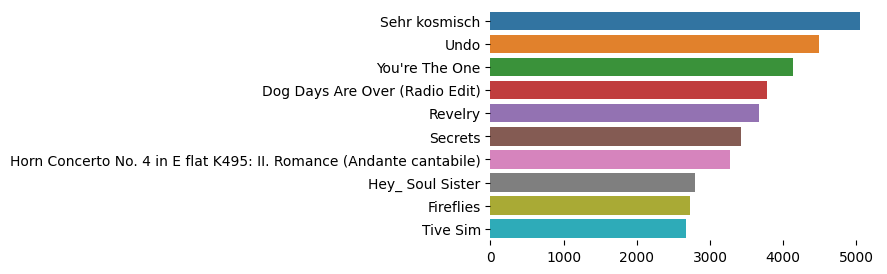

In [11]:
plt.figure(figsize=(5,3))
sns.barplot(x=top10['listen_count'].tolist(), y=top10['title'].tolist())
sns.despine(left=True, bottom=True)

**GRAPH: Top 10 artists**

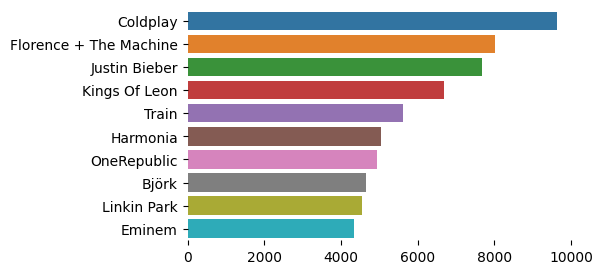

In [12]:
plt.figure(figsize=(5,3))
sns.barplot(x=art10['listen_count'].tolist(), y=art10['artist_name'].tolist())
sns.despine(left=True, bottom=True)

In [13]:
Avg = df.groupby('user_id')['song_id'].count().reset_index().sort_values(['song_id', 'user_id'], ascending = [0,1])
print(f"Average no. of songs a user listens to is {round(Avg['song_id'].mean(),2)}" )

Average no. of songs a user listens to is 4.95


<Figure size 1000x500 with 0 Axes>

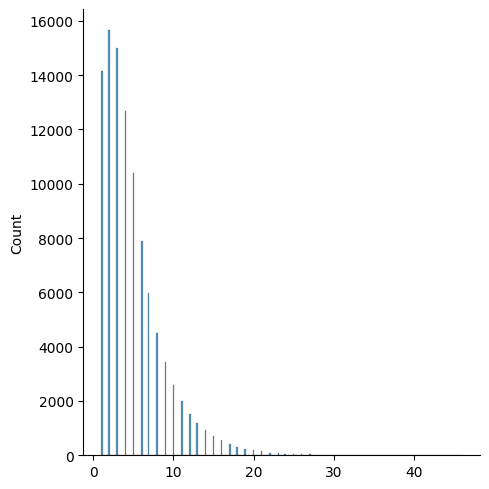

In [14]:
Avg_graph = df.groupby('user_id')['song_id'].count()

plt.figure(figsize=(10, 5))
sns.displot(Avg_graph.values,palette='muted')
plt.show();

* From the graph above we notice that most users listen 1-10 songs on average.

### Recommender

In [15]:
import numpy as np
import pandas

#Class for Popularity based Recommender System model
class popularity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

        #Get a count of user_ids for each unique song as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {'user_id': 'score'},inplace=True)
    
        #Sort the songs based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(10)

    #Use the popularity based recommender system model to
    #make recommendations
    def recommend(self, user_id):    
        user_recommendations = self.popularity_recommendations
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
    
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]
        
        return user_recommendations
    

#Class for Item similarity based Recommender System model
class item_similarity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.cooccurence_matrix = None
        self.songs_dict = None
        self.rev_songs_dict = None
        self.item_similarity_recommendations = None
        
    #Get unique items (songs) corresponding to a given user
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data[self.user_id] == user]
        user_items = list(user_data[self.item_id].unique())
        
        return user_items
        
    #Get unique users for a given item (song)
    def get_item_users(self, item):
        item_data = self.train_data[self.train_data[self.item_id] == item]
        item_users = set(item_data[self.user_id].unique())
            
        return item_users
        
    #Get unique items (songs) in the training data
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.item_id].unique())
            
        return all_items
        
    #Construct cooccurence matrix
    def construct_cooccurence_matrix(self, user_songs, all_songs):
            
        ####################################
        #Get users for all songs in user_songs.
        ####################################
        user_songs_users = []        
        for i in range(0, len(user_songs)):
            user_songs_users.append(self.get_item_users(user_songs[i]))
            
        ###############################################
        #Initialize the item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)
           
        #############################################################
        #Calculate similarity between user songs and all unique songs
        #in the training data
        #############################################################
        for i in range(0,len(all_songs)):
            #Calculate unique listeners (users) of song (item) i
            songs_i_data = self.train_data[self.train_data[self.item_id] == all_songs[i]]
            users_i = set(songs_i_data[self.user_id].unique())
            
            for j in range(0,len(user_songs)):       
                    
                #Get unique listeners (users) of song (item) j
                users_j = user_songs_users[j]
                    
                #Calculate intersection of listeners of songs i and j
                users_intersection = users_i.intersection(users_j)
                
                #Calculate cooccurence_matrix[i,j] as Jaccard Index
                if len(users_intersection) != 0:
                    #Calculate union of listeners of songs i and j
                    users_union = users_i.union(users_j)
                    
                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                else:
                    cooccurence_matrix[j,i] = 0
                    
        
        return cooccurence_matrix

    
    #Use the cooccurence matrix to make top recommendations
    def generate_top_recommendations(self, user, cooccurence_matrix, all_songs, user_songs):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))
        
        #Calculate a weighted average of the scores in cooccurence matrix for all user songs.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
 
        #Sort the indices of user_sim_scores based upon their value
        #Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        #Create a dataframe from the following
        columns = ['user_id', 'song', 'score', 'rank']
        #index = np.arange(1) # array of numbers for the number of samples
        df = pandas.DataFrame(columns=columns)
         
        #Fill the dataframe with top 10 item based recommendations
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                df.loc[len(df)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no songs for training the item similarity based recommendation model.")
            return -1
        else:
            return df
 
    #Create the item similarity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

    #Use the item similarity based recommender system model to
    #make recommendations
    def recommend(self, user):
        
        ########################################
        #A. Get all unique songs for this user
        ########################################
        user_songs = self.get_user_items(user)    
            
        print("No. of unique songs for the user: %d" % len(user_songs))
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
                
        return df_recommendations
    
    #Get similar items to given items
    def get_similar_items(self, item_list):
        
        user_songs = item_list
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        user = ""
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
         
        return df_recommendations

### Engine

In [16]:
pop = popularity_recommender_py()

In [17]:
pop.create(df,'user_id','title')

In [18]:
pop.recommend(df['user_id'][56])

,user_id,title,score,Rank
4388,ca0389325d560df3809ad1d126a838eec73b0a1d,Sehr kosmisch,5043,1.0
5613,ca0389325d560df3809ad1d126a838eec73b0a1d,Undo,4483,2.0
6126,ca0389325d560df3809ad1d126a838eec73b0a1d,You're The One,4136,3.0
1256,ca0389325d560df3809ad1d126a838eec73b0a1d,Dog Days Are Over (Radio Edit),3780,4.0
4147,ca0389325d560df3809ad1d126a838eec73b0a1d,Revelry,3672,5.0
4378,ca0389325d560df3809ad1d126a838eec73b0a1d,Secrets,3430,6.0
2207,ca0389325d560df3809ad1d126a838eec73b0a1d,Horn Concerto No. 4 in E flat K495: II. Romanc...,3272,7.0
2142,ca0389325d560df3809ad1d126a838eec73b0a1d,Hey_ Soul Sister,2791,8.0
1658,ca0389325d560df3809ad1d126a838eec73b0a1d,Fireflies,2725,9.0
5444,ca0389325d560df3809ad1d126a838eec73b0a1d,Tive Sim,2668,10.0


In [19]:
# Create an object to store the class
sim = item_similarity_recommender_py()

# Using the same object filter a class
sim.create(df,'user_id','title')

**Using specific user id listen history, the model can recommend similar songs**

In [20]:
sim.recommend(df['user_id'][14])

No. of unique songs for the user: 27
no. of unique songs in the training set: 6183
Non zero values in cooccurence_matrix :36424


,user_id,song,score,rank
0,4fbde29be137e7179046c148f9e15db17c3278be,Revelry,0.023829,1
1,4fbde29be137e7179046c148f9e15db17c3278be,Sehr kosmisch,0.019945,2
2,4fbde29be137e7179046c148f9e15db17c3278be,Hey_ Soul Sister,0.018541,3
3,4fbde29be137e7179046c148f9e15db17c3278be,Dog Days Are Over (Radio Edit),0.018419,4
4,4fbde29be137e7179046c148f9e15db17c3278be,Drop The World,0.018322,5
5,4fbde29be137e7179046c148f9e15db17c3278be,Fireflies,0.018209,6
6,4fbde29be137e7179046c148f9e15db17c3278be,Marry Me,0.016540,7
7,4fbde29be137e7179046c148f9e15db17c3278be,Ain't Misbehavin,0.016117,8
8,4fbde29be137e7179046c148f9e15db17c3278be,Tive Sim,0.016110,9
9,4fbde29be137e7179046c148f9e15db17c3278be,Pursuit Of Happiness (nightmare),0.015990,10


**Pass songs in the class, it will suggest similar songs**

In [21]:
sim.get_similar_items(['Yellow','Invalid'])

no. of unique songs in the training set: 6183
Non zero values in cooccurence_matrix :4343


,user_id,song,score,rank
0,,Clocks,0.051251,1
1,,The Scientist,0.046670,2
2,,Fix You,0.042234,3
3,,Horn Concerto No. 4 in E flat K495: II. Romanc...,0.039735,4
4,,Revelry,0.038853,5
5,,Undo,0.038257,6
6,,You're The One,0.036146,7
7,,Représente,0.035977,8
8,,Catch You Baby (Steve Pitron & Max Sanna Radio...,0.035769,9
9,,Tive Sim,0.035400,10
